# HONR 39900 Fall 2021: Foundations of Geospatial Analytics
## Weeks 5 and 6 Class Notebook
## Advanced PostGIS Usage

### Justin A. Gould (gould29@purdue.edu)

# Required Packages

In [1]:
import geopandas as gpd
from sqlalchemy import create_engine, text
from sqlalchemy_utils import create_database, database_exists, drop_database
import pandas as pd
import sqlalchemy

# Load Data \#1
Today, we will be working with the `boroughs` data from Chapter 11 of our [textbook](http://postgis.us/).

In [2]:
nyc = gpd.read_file("./nyc_boroughs/geo_export_b38c64b9-7e50-43c7-8880-994b22440dbf.shp")

In [3]:
nyc.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,9.442947e+08,203803.216852,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.0,Bronx,1.598380e+09,188054.198841,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3.0,Brooklyn,2.684411e+09,234928.658563,"POLYGON ((-73.92722 40.72533, -73.92654 40.724..."
3,4.0,Queens,3.858050e+09,429586.630985,"POLYGON ((-73.77896 40.81171, -73.76371 40.793..."
4,5.0,Staten Island,2.539686e+09,212213.139971,"POLYGON ((-74.05581 40.64971, -74.05619 40.639..."


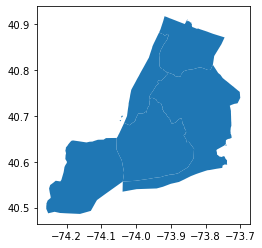

In [4]:
nyc.plot()

# Connect to Postgres

In [5]:
#Variables
db_type = "postgres"
username = "postgres"
password = ""
host = "localhost"
port = "5432"
db_name = "demo"

#Put it together
engine = create_engine(f"{db_type}://{username}:{password}@{host}:{port}/{db_name}")

In [21]:
#Write nyc to PostgreSQL
nyc.to_postgis(name="boroughs_chapter_11", con=engine)

In [6]:
engine.table_names() #We see that our table was added to our database

['spatial_ref_sys',
 'london',
 'airbnb_homework_4',
 'streets_chapter_11',
 'boroughs_chapter_11']

# Loading Rest of Chapter 11 Data
Follow these steps:
1. `cd` into `./ch11/data`
2. Run: `psql -U YOUR_USERNAME -d YOUR_DATABASE -f ch11_data.sql`. This will add all data to your postgres DB.

In [51]:
%%bash
cd ./ch11/data/
psql -h ananke-a000.rcac.purdue.edu -U postgres -p 32029 -d gould29 -f ch11_data.sql

SET
SET
ALTER TABLE
ALTER TABLE
ALTER SEQUENCE
ALTER SEQUENCE
ALTER TABLE
ALTER SEQUENCE
ALTER TABLE
ALTER TABLE
ALTER TABLE
 setval 
--------
    115
(1 row)

 setval 
--------
      5
(1 row)

 setval 
--------
  16984
(1 row)



psql:ch11_data.sql:11: ERROR:  schema "ch11" already exists
psql:ch11_data.sql:62: ERROR:  schema "postgis" does not exist
psql:ch11_data.sql:65: ERROR:  function ch11.upgis_cutlineatpoints(geometry, geometry, double precision) does not exist
psql:ch11_data.sql:103: ERROR:  relation "aussie_track_points" already exists
psql:ch11_data.sql:125: ERROR:  relation "aussie_tracks" already exists
psql:ch11_data.sql:143: ERROR:  relation "boroughs" already exists
psql:ch11_data.sql:159: ERROR:  relation "cities" already exists
psql:ch11_data.sql:172: ERROR:  relation "cities_gid_seq" already exists
psql:ch11_data.sql:194: ERROR:  relation "nybbwi_gid_seq" already exists
psql:ch11_data.sql:245: ERROR:  relation "stclines_streets" already exists
psql:ch11_data.sql:259: ERROR:  relation "stclines_streets_gid_seq" already exists
psql:ch11_data.sql:2772: ERROR:  duplicate key value violates unique constraint "aussie_track_points_pkey"
DETAIL:  Key (ogc_fid)=(1) already exists.
CONTEXT:  COPY aussie

In [7]:
#List Schemas
insp = sqlalchemy.inspect(engine)
insp.get_schema_names()

['ch11', 'information_schema', 'public']

# Review: Accessing our Postgres Data
Whenever we use Jupyter Notebooks to access and use our data from postgres, you can use the beginning of this notebook as a standard boilerplate. Be sure to take the notebook with you from class! :)

In [8]:
#SQL query
sql = "SELECT * FROM public.boroughs_chapter_11"

#Specify name of column which stores our geometry! In table `streets_chapter_11`, the geometry is stored in a col called `geometry`
geom_col = "geometry"

#Execute query to create GeoDataFrame
nyc_from_db = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col=geom_col)

In [9]:
nyc_from_db.head() #Yay!

,boro_code,boro_name,shape_area,shape_leng,geometry
0,1.0,Manhattan,9.442947e+08,203803.216852,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,2.0,Bronx,1.598380e+09,188054.198841,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3.0,Brooklyn,2.684411e+09,234928.658563,"POLYGON ((-73.92722 40.72533, -73.92654 40.724..."
3,4.0,Queens,3.858050e+09,429586.630985,"POLYGON ((-73.77896 40.81171, -73.76371 40.793..."
4,5.0,Staten Island,2.539686e+09,212213.139971,"POLYGON ((-74.05581 40.64971, -74.05619 40.639..."


# Agenda
We have a **LOT** to cover today...here's a snapshot:

Topic Name                                                           | Textbook Chapter/Section
:------                                                              | ------:
Creating a single `MULTIPOLYGON` from many                           | 11.1.1 
Creating a `LINESTRING` from `POINT`s                                | 11.1.2
Clipping                                                             | 11.2.1
Splitting                                                            | 11.2.2
Tessellating                                                         | 11.2.3
Sharding                                                             | 11.2.3
Segmentizing `LINESTRING`s                                           | 11.3.1
Scaling                                                              | 11.4.2
Rotating                                                             | 11.4.3

# Creating a single `MULTIPOLYGON` from many
Textbook Chapter/Section: 11.1.1 \
Textbook Start Page: 310

In many cases, you may have a city where records are broken out by districts, neighborhoods, boroughs, or precincts because you often need to view or report on each neighborhood separately. Sometimes, however, for reporting purposes you need to view the city as a single unit. In this case you can use the `ST_UNION` aggregate function to amass one single multipolygon from constituent multipolygons.

For example, the largest city in the United States is New York, made up of the five storied boroughs of Manhattan, Bronx, Queens, Brooklyn, and Staten Island. To aggregate New York, you first need to create a boroughs table with five records—one multipolygon for each of the boroughs with littorals:

![Image 1](./images/image_1.png)


Then you can use the `ST_Union` spatial aggregate function to group all the boroughs into a single city, as follows:

In [10]:
sql = """
SELECT 
    ST_Union(geometry) AS city
FROM
    public.boroughs_chapter_11;
"""

example_11_1_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="city") #Note the change in geom_col!

In [11]:
example_11_1_1.head()

,city
0,"MULTIPOLYGON (((-74.03844 40.55674, -74.04955 ..."


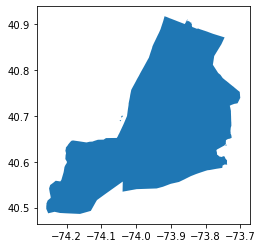

In [12]:
example_11_1_1.plot()

Let’s work through an example in the San Francisco area using our table of cities. This example lists cities that straddle multiple records, how many polygons each city straddles, and how many polygons you’ll be left with after dissolving boundaries within each city.

In [13]:
sql = """
SELECT
    city,
    COUNT(city) AS num_records,
    SUM(ST_NumGeometries(geom)) AS numpoly_before,
    ST_NumGeometries(ST_Multi(ST_Union(geom))) AS num_poly_after,
    ST_PointFromText('POINT(0 0)') AS dummy
FROM
    ch11.cities
GROUP BY
    city, dummy
HAVING
    COUNT(city) > 1;
"""

ex_11_1_1_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="dummy") #Note the change in geom_col!

In [14]:
ex_11_1_1_2

,city,num_records,numpoly_before,num_poly_after,dummy
0,ALAMEDA,4,4,4,POINT (0.00000 0.00000)
1,BELVEDERE TIBURON,2,2,2,POINT (0.00000 0.00000)
2,BRISBANE,2,2,1,POINT (0.00000 0.00000)
3,GREENBRAE,2,2,2,POINT (0.00000 0.00000)
4,LARKSPUR,2,2,2,POINT (0.00000 0.00000)
5,REDWOOD CITY,2,2,2,POINT (0.00000 0.00000)
6,SAN FRANCISCO,7,7,6,POINT (0.00000 0.00000)
7,SAN MATEO,2,2,2,POINT (0.00000 0.00000)
8,SOUTH SAN FRANCISCO,2,2,2,POINT (0.00000 0.00000)
9,SUISUN CITY,2,2,2,POINT (0.00000 0.00000)


From the code above, you know that ten cities have multiple records, but you’ll only be able to dissolve the boundaries of Brisbane and San Francisco, because only these two have fewer polygons per geometry than what you started out with.

Below, you will aggregate and insert the aggregated records into a table called `ch11.distinct_cities`. You then add a primary key to each city to ensure that you have exactly one record per city...

In [15]:
#New Table
sql = """SELECT city, ST_Multi(
    ST_Union(geom))::geometry(multipolygon,2227) AS geom
FROM ch11.cities
GROUP BY city, ST_SRID(geom);
"""
new_ex_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note the change in geom_col!

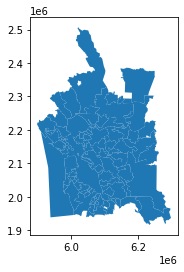

In [16]:
new_ex_1.plot()

In [18]:
#Add to db
new_ex_1.to_postgis(name="distinct_cities", schema="ch11", con=engine)

In [19]:
#New Table
sql = """
SELECT
    *
FROM
    ch11.distinct_cities
"""
new_ex_1_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note the change in geom_col!

In [20]:
new_ex_1_1.head()

,city,geom
0,ALAMEDA,"MULTIPOLYGON (((6062440.660 2099431.510, 60623..."
1,ALAMO,"MULTIPOLYGON (((6142769.437 2132420.993, 61418..."
2,ALBANY,"MULTIPOLYGON (((6045760.680 2154419.700, 60461..."
3,ALVISO,"MULTIPOLYGON (((6133654.370 1993195.000, 61330..."
4,AMERICAN CANYON,"MULTIPOLYGON (((6072029.630 2267404.510, 60811..."


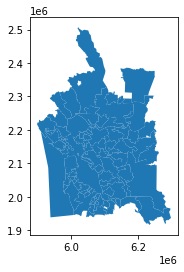

In [21]:
new_ex_1_1.plot()

In the above code, you create and populate a new table called `ch11.distinct_cities`. You use the `ST_Multi` function to ensure that all the resulting geometries will be multipolygons and not polygons. If a geometry has a single polygon, `ST_Multi` will upgrade it to be a multipolygon with a single polygon. Then you cast the geometry using typmod to ensure that the geometry type and spatial reference system are correctly registered in the `geometry_columns` view. For good measure we also put in a primary key and a spatial index.

# Creating a `LINESTRING` from `POINT`s
Textbook Chapter/Section: 11.1.2 \
Textbook Start Page: 312

In the past two decades, the use of GPS devices has gone mainstream. GPS Samaritans spend their leisure time visiting points of interest (POI), taking GPS readings, and sharing their adventures via the web. Common venues have included local taverns, eateries, fishing holes, and filling stations with the lowest prices. A common follow-up task after gathering the raw positions of the POIs is to connect them to form an unbroken course.

In this exercise, you’ll use Australian track points to create linestrings. These track points consist of GPS readings taken during a span of about ten hours from afternoon to early morning on a wintry July day. We have no idea of what the readings represent. Let’s say a zoologist fastened a GPS around the neck of a roo and tracked her for an evening. The readings came in every ten seconds or so, but instead of creating one line-string with more than two thousand points, you’ll divide the readings into 15-minute intervals and create separate linestrings for each of the intervals.

`ST_MakeLine` is the spatial aggregate function that takes a set of points and forms a linestring out of them. You can add an `ORDER BY` clause to aggregate functions; this is particularly useful when you need to control the order in which aggregation occurs. In this example, you’ll order by the input time of the readings.

In [22]:
sql = """
SELECT
    DATE_TRUNC('minute',time) -
CAST( mod(
                CAST(DATE_PART('minute',time) AS integer),15
            ) ||' minutes' AS interval
        ) AS track_period,
    MIN(time) AS t_start,
    MAX(time) AS t_end,
    ST_MakeLine(geom ORDER BY time) AS geom
INTO ch11.aussie_run
FROM ch11.aussie_track_points
GROUP BY track_period
HAVING COUNT(time) > 1;
SELECT
    CAST(track_period AS timestamp),
    CAST(t_start AS timestamp) AS t_start,
    CAST(t_end AS timestamp) AS t_end,
    ST_NPoints(geom) AS number_of_points,
    CAST(ST_Length(geom::geography) AS integer) AS dist_m,
    (t_end - t_start) AS dur,
    geom
FROM ch11.aussie_run;
"""

example_11_1_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom")

In [23]:
example_11_1_2.head()

,track_period,t_start,t_end,number_of_points,dist_m,dur,geom
0,2009-07-18 04:30:00,2009-07-18 04:30:00,2009-07-18 04:44:59,133,2705,0 days 00:14:59,"LINESTRING (152.95709 -27.16209, 152.95704 -27..."
1,2009-07-18 04:45:00,2009-07-18 04:45:05,2009-07-18 04:55:20,87,1720,0 days 00:10:15,"LINESTRING (152.94813 -27.17278, 152.94828 -27..."
2,2009-07-18 05:00:00,2009-07-18 05:02:00,2009-07-18 05:14:59,100,1530,0 days 00:12:59,"LINESTRING (152.94259 -27.17509, 152.94265 -27..."
3,2009-07-18 05:15:00,2009-07-18 05:15:05,2009-07-18 05:29:59,149,3453,0 days 00:14:54,"LINESTRING (152.94276 -27.17723, 152.94263 -27..."
4,2009-07-18 05:30:00,2009-07-18 05:30:05,2009-07-18 05:43:58,132,3059,0 days 00:13:53,"LINESTRING (152.94757 -27.18276, 152.94754 -27..."


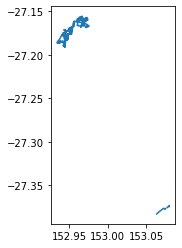

In [24]:
example_11_1_2.plot()

First you create a column called `track_period` specifying quarter-hour slots starting on the hour, 15 minutes past, 30 minutes past, and 45 minutes past. You allocate each GPS point into the slots and create separate linestrings from each time slot via the `GROUP BY` clause. Not all time slots need to have points, and some slots may have a single point. If a slot is devoid of points, it won’t be part of the output. If a slot only has one point, it’s removed. For the allocation, you use the data_part function and the modulo operator.

Within each slot, you create a `linestring` using `ST_MakeLine`. You want the line to follow the timing of the measurements, so you add an `ORDER BY` clause to `ST_MakeLine`.

The `SELECT` inserts directly into a new table called `aussie_run`. (If you’re not running this code for the first time, you’ll need to drop the `aussie_run` table first.) Finally, you query `aussie_run` to find the number of points in each `linestring` using `ST_NPoints`, subtracting the time of the last point from the time of the first point to get a duration, and using `ST_Length` to compute the distance covered between the first and last points within the 15-minute slot. Note that you cast the geometry in longitude and latitude to geography to ensure you have a measurable unit—meters.

![Image 2](./images/image_2.png)

# Clipping
Textbook Chapter/Section: 11.2.1 \
Textbook Start Page: 314

Clipping uses one geometry to cut another during intersection.Clipping uses one geometry to cut another during intersection. In this section, we’ll explore other functions available to you for clipping and splitting.In this section, we’ll explore other functions available to you for clipping and splitting.

As the name implies, _clipping_ is the act of removing unwanted sections of a geometry, leaving behind only what’s of interest. Think of clipping coupons from a newspaper, clipping hair from someone’s head, or the moon clipping the sun in a solar eclipse.

_Difference_ and _symmetric difference_ are operations closely related to intersection. They both serve to return the remainder of an intersection. `ST_Difference` is a non—commutative function, whereas `ST_SymDifference` is, as the name implies, commutative.As the name implies, clipping is the act of removing unwanted sections of a geometry, leaving behind only what’s of interest. Think of clipping coupons from a newspaper, clipping hair from someone’s head, or the moon clipping the sun in a solar eclipse.

Difference and symmetric difference are operations closely related to intersection. They both serve to return the remainder of an intersection. `ST_Difference` is a non—commutative function, whereas ST_SymDifference is, as the name implies, commutative.

Difference functions return the geometry of what’s left out when two geometries intersect. When given geometries `A` and `B`, `ST_Difference(A,B)` returns the portion of `A` that’s not shared with `B`, whereas `ST_SymDifference(A,B)` returns the portion of `A` and `B` that’s not shared. Difference functions return the geometry of what’s left out when two geometries intersect. When given geometries `A` and `B`, `ST_Difference(A,B)` returns the portion of `A` that’s not shared with `B`, whereas `ST_SymDifference(A,B)` returns the portion of `A` and `B` that’s not shared.

```
ST_SymDifference(A,B) =  Union(A,B) - Intersection(A,B)
ST_Difference(A,B) = A - Intersection(A,B)
```

## Example: What’s left of the polygon and line after clipping
Here, you’re getting the difference between a linestring and polygon

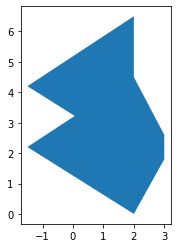

In [25]:
#This is what our polygon looks like
sql = """
SELECT ST_GeomFromText(
        'POLYGON((
            2 4.5,3 2.6,3 1.8,2 0,-1.5 2.2,
            0.056 3.222,-1.5 4.2,2 6.5,2 4.5
        ))'
    ) AS geom1
"""

poly = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom1") #Note change of geom_col!
poly.plot()

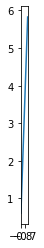

In [26]:
#This is what our polygon looks like
sql = """
SELECT ST_GeomFromText('LINESTRING(-0.62 5.84,-0.8 0.59)') AS geom2
"""

LS = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom2") #Note change of geom_col!
LS.plot()

In [27]:
#The difference between the polygon and linestring is a polygon
sql = """
SELECT
    ST_Intersects(g1.geom1,g1.geom2) AS they_intersect,
    GeometryType(
        ST_Difference(g1.geom1,g1.geom2) ) AS intersect_geom_type,
    ST_Difference(g1.geom1,g1.geom2) AS intersect
FROM (
    SELECT ST_GeomFromText(
        'POLYGON((
            2 4.5,3 2.6,3 1.8,2 0,-1.5 2.2,
            0.056 3.222,-1.5 4.2,2 6.5,2 4.5
        ))'
    ) AS geom1,
    ST_GeomFromText('LINESTRING(-0.62 5.84,-0.8 0.59)') AS geom2
) AS g1;
"""

example_11_2_1_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="intersect") #Note change of geom_col!
example_11_2_1_1.head()

,they_intersect,intersect_geom_type,intersect
0,True,POLYGON,"POLYGON ((2.00000 4.50000, 3.00000 2.60000, 3...."


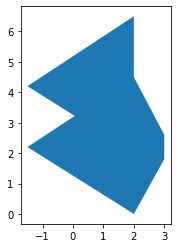

In [28]:
example_11_2_1_1.plot()

In [29]:
#The difference between the linestring and polygon is a multilinestring
sql = """
SELECT
    ST_Intersects(g1.geom1,g1.geom2) AS they_intersect,
    GeometryType(
        ST_Difference(g1.geom2,g1.geom1) ) AS intersect_geom_type,
    ST_Difference(g1.geom2,g1.geom1) AS intersect
FROM (
    SELECT ST_GeomFromText(
        'POLYGON((
            2 4.5,3 2.6,3 1.8,2 0,-1.5 2.2,
            0.056 3.222,-1.5 4.2,2 6.5,2 4.5
        ))'
    ) AS geom1,
    ST_GeomFromText('LINESTRING(-0.62 5.84,-0.8 0.59)') AS geom2) AS g1;
"""
    
example_11_2_1_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="intersect") #Note change of geom_col!
example_11_2_1_2.head()

,they_intersect,intersect_geom_type,intersect
0,True,MULTILINESTRING,"MULTILINESTRING ((-0.62000 5.84000, -0.65724 4..."


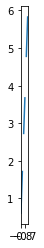

In [30]:
example_11_2_1_2.plot()

In [31]:
#The symmetric difference is a geometry collection
sql = """
SELECT
    ST_Intersects(g1.geom1,g1.geom2) AS they_intersect,
    GeometryType(
        ST_SymDifference(g1.geom1,g1.geom2)
    ) AS intersect_geom_type,
    ST_SymDifference(g1.geom2,g1.geom1) AS intersect
FROM (
    SELECT ST_GeomFromText(
        'POLYGON((
            2 4.5,3 2.6,3 1.8,2 0,-1.5 2.2,
            0.056 3.222,-1.5 4.2,2 6.5,2 4.5
        ))'
    ) AS geom1,
    ST_GeomFromText('LINESTRING(-0.62 5.84,-0.8 0.59)') AS geom2) AS g1;
"""
example_11_2_1_3 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="intersect") #Note change of geom_col!
example_11_2_1_3.head()

,they_intersect,intersect_geom_type,intersect
0,True,GEOMETRYCOLLECTION,GEOMETRYCOLLECTION (LINESTRING (-0.62000 5.840...


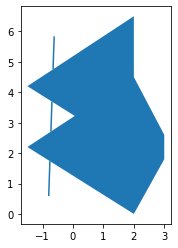

In [32]:
example_11_2_1_3.plot()

In the preceding listing, the first `SELECT` returns a polygon #1, which is pretty much the same polygon you started out with. The second `SELECT` returns a `multilinestring` composed of three `linestring`s where the `polygon` cuts through #2. Finally, the third `SELECT` returns a `geometrycollection` as expected, composed of a `multilinestring` and a `polygon` #3.

![Image 3](./images/image_3.png)

# Splitting
Textbook Chapter/Section: 11.2.2 \
Textbook Start Page: 316

You just learned that using a `linestring` to slice a `polygon` with `ST_Difference` doesn’t work. For that, PostGIS offers another function called `ST_Split`. The `ST_Split` function can only be used with single geometries, not collections, and the blade you use to cut has to be one dimension lower than what you’re cutting up.

The following listing demonstrates the use of `ST_Split`.

In [35]:
sql = """SELECT gd.path[1] AS index, gd.geom AS geom
FROM (
    SELECT
        ST_GeomFromText(
            'POLYGON((
                2 4.5,3 2.6,3 1.8,2 0,-1.5 2.2,0.056
            3.222,-1.5 4.2,2 6.5,2 4.5
            ))'
) AS geom1,
        ST_GeomFromText('LINESTRING(-0.62 5.84,-0.8 0.59)') AS geom2
) AS g1,
  ST_Dump(ST_Split(g1.geom1, g1.geom2)) AS gd"""
example_11_2_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
example_11_2_2.head()

,index,geom
0,1,"POLYGON ((2.00000 4.50000, 3.00000 2.60000, 3...."
1,2,"POLYGON ((-0.76073 1.73532, -1.50000 2.20000, ..."
2,3,"POLYGON ((-0.69361 3.69315, -1.50000 4.20000, ..."


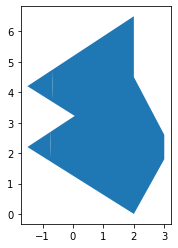

In [36]:
example_11_2_2.plot()

The `ST_Split(A,B)` function always returns a geometry collection consisting of all parts of geometry `A` that result from splitting it with geometry `B`, even when the result is a single geometry.

Because of the inconvenience of geometry collections, you’ll often see `ST_Split` combined with `ST_Dump`, as in the above listing, or with `ST_CollectionExtract` to simplify down to a single geometry where possible.

![Image 4](./images/image_4.png)

# Tessellating
Textbook Chapter/Section: 11.2.3 \
Textbook Start Page: 318

Dividing your polygon into regions using shapes such as rectangles, hexagons, and triangles is called tessellating. It’s often desirable to divide your regions into areas that have equal area or population for easier statistical analysis. In this section, we’ll demonstrate techniques for achieving equal-area regions.

Tessellating looks like this:

![Tessellating](https://www.math-salamanders.com/image-files/tessellating-triangles.gif)


## CREATING A GRID AND SLICING TABLE GEOMETRIES WITH THE GRID
In this example, you’ll slice the New York city boroughs into small rectangular blocks. Your map will look like this:

![Image 5](./images/image_5.png)

We will first start off with `ST_SquareGrid`. `ST_SquareGrid` is a set returning function that returns a table consisting of 3 columns `(i,j,geom)`. The `i` is the row number along the grid and `j` is the column number along the grid.

In [40]:
sql = """
WITH bounds AS (
     SELECT ST_SetSRID(ST_Extent(geom), ST_SRID(geom)) AS geom -- Creates a bounding box geometry covering the extent of the boroughs
        FROM ch11.boroughs
    GROUP BY ST_SRID(geom)
 ),
 grid AS (SELECT g.i, g.j, g.geom
          FROM bounds, ST_SquareGrid(10000,bounds.geom) AS g
          )                                                    -- Creates a square grid each square grid is of 10000 length/width units (feet)
 SELECT b.boroname, grid.i, grid.j,
      CASE WHEN ST_Covers(b.geom,grid.geom) THEN grid.geom
      ELSE ST_Intersection(b.geom, grid.geom) END AS geom      -- Clips the boroughs by the squares
 FROM ch11.boroughs AS b
     INNER JOIN grid ON ST_Intersects(b.geom, grid.geom);
"""

example_11_2_3_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
example_11_2_3_1.head()

,boroname,i,j,geom
0,Staten Island,91,11,"POLYGON ((920000.000 117907.700, 918916.902 11..."
1,Staten Island,91,12,"POLYGON ((912498.141 120000.000, 912287.069 12..."
2,Staten Island,91,13,"POLYGON ((915779.150 130000.000, 915731.347 13..."
3,Staten Island,91,14,"POLYGON ((916233.310 140000.000, 917776.001 14..."
4,Staten Island,92,11,"POLYGON ((930000.000 116834.215, 928239.005 11..."


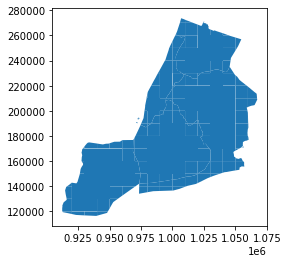

In [38]:
example_11_2_3_1.plot()

In [39]:
#Add to db
example_11_2_3_1.to_postgis(name="boroughs_square_grid", schema="ch11", con=engine)

The above code uses a grid where each square is 10,000 units in length/width and spans the full extent of NYC boroughs. Since the boroughs are in NY State plane feet (SRID=2263), the units of measure are square feet. When you clip the bouroughs by the grid, the resulting tiles have various shapes and sizes when they are on bourough boundaries. This may not be ideal if you want all your tiles to be the same size. In those cases you may want to forgo the clipping and just return the squares as is. Note that <3> uses a CASE statement. This is equivalent in result to just doing ST_Intersection, but because ST_Intersection is an intensive operation, you save a lot of processing cycles by just returning the square if it is completely covered by the borough.


The above code defined a bounds that covered the whole area of interest and split that into squares and then clipped the geometries using those squares. One feature of the ST_SquareGrid function that is not obvious from the above code is that for any given SRID and size there is a unique dicing of grids that can be formed across all space. Which means for any given SRID and size a particular point will have exactly the same i,j, geom tile it intersects in.

In [41]:
#Dividing the NYC boroughs bounds into rectangular blocks
#This code creates a square grid each square grid is of 10000 sq units (feet)
sql = """
SELECT b.boroname, grid.i, grid.j,
    CASE WHEN ST_Covers(b.geom,grid.geom) THEN grid.geom
      ELSE ST_Intersection(b.geom, grid.geom) END AS geom             -- Creates a bounding box geometry covering the extent of the boroughs
 FROM ch11.boroughs AS b
     INNER JOIN ST_SquareGrid(10000,b.geom) AS grid                   -- Clips the boroughs by the squares
      ON ST_Intersects(b.geom, grid.geom);
"""

example_11_2_3_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
example_11_2_3_2.head()

,boroname,i,j,geom
0,Staten Island,91,11,"POLYGON ((920000.000 117907.700, 918916.902 11..."
1,Staten Island,91,12,"POLYGON ((912498.141 120000.000, 912287.069 12..."
2,Staten Island,91,13,"POLYGON ((915779.150 130000.000, 915731.347 13..."
3,Staten Island,91,14,"POLYGON ((916233.310 140000.000, 917776.001 14..."
4,Staten Island,92,11,"POLYGON ((930000.000 116834.215, 928239.005 11..."


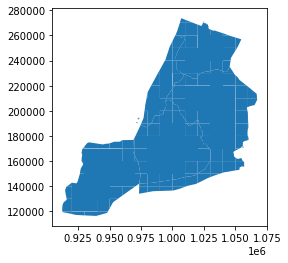

In [42]:
example_11_2_3_2.plot() #Note it is the same result as before

In [43]:
#Add to db
example_11_2_3_2.to_postgis(name="boroughs_square_grid2", schema="ch11", con=engine)

If this is a grid you’ll be using often, it’s best to make a physical table (materialize it) out of the bounds and use it to chop up your area as needed. However if this is one off chunking for specific areas or your area is huge and you want to do it in bits, then it is better to follow the listing 11.5 model.

Often times a hexagonal grid works better for splitting space evenly as each hexagon has 6 neighbors it is equidistant to. This is not the case with squares. A popular gridding system for the world is the H3 scheme created by Uber for dividing driving regions. It uses hexagons https://eng.uber.com/h3/ to divide the earth and a dymaxion projection https://en.wikipedia.org/wiki/Dymaxion_map. This has the feature of allowing large hexagons to more or less contain smaller ones.

# Sharding
Textbook Chapter/Section: 11.2.3 \
Textbook Start Page: 327

One common reason for breaking a geometry into smaller bits is for performance. The reason is that operations such as intersections and intersects work much faster on geometries with fewer points or smaller area. If you have such a need, the fastest sharding function is the `ST_Subdivide`(https://postgis.net/docs/ST_Subdivide.html) function. `ST_Subdivide` is a set returning function that returns a set of geometries where no geometry has more than max_vertices designated. It can work with areal, linear, and point geometries.

This next example divides Queens such that no polygon has more than 1/4th total vertices of original.

In [44]:
sql = """
SELECT row_number() OVER() AS bucket,x.geom,
  ST_Area(x.geom) AS area,
  ST_NPoints(x.geom) AS npoints,
  (ref.npoints/4)::integer As max_vertices
FROM (SELECT geom,                                             -- Geometry to slice
        ST_NPoints(geom) AS npoints
      FROM ch11.boroughs WHERE boroname = 'Queens') AS ref
         , LATERAL ST_Subdivide(ref.geom,
                  (ref.npoints/4)::integer                     -- Max number shards
                  ) AS x(geom) ;
"""

example_11_2_3_3 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
example_11_2_3_3.head()

,bucket,geom,area,npoints,max_vertices
0,1,"POLYGON ((1016187.550 141290.140, 1011914.750 ...",3.266832e+08,26,239
1,2,"POLYGON ((1039907.726 150741.984, 1034839.909 ...",5.422707e+08,73,239
2,3,"POLYGON ((1048784.526 167596.255, 1048727.701 ...",2.061526e+08,166,239
3,4,"POLYGON ((1059790.715 184428.326, 1059759.660 ...",2.899369e+08,88,239
4,5,"POLYGON ((1031087.953 184428.326, 1022870.118 ...",5.098495e+08,161,239


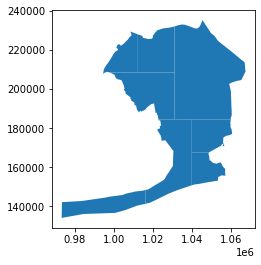

In [45]:
example_11_2_3_3.plot()

Here is a color-coded example of the above plot:
    
![Image 6](./images/image_6.png)




You will often find `ST_Subdivide` paired with `ST_Segmentize`. `ST_Segmentize` is used to even out the segments so that when `ST_Subdivide` does the work of segmentizing, the areas have a better chance of being equal.

In the above queries with `ST_Subdivide` use `LATERAL` join constructs. In the case of set-returning functions, the `LATERAL` keyword is optional so you will find people often ommitting `LATERAL` even though they are doing a `LATERAL` join.

# Segmentizing `LINESTRING`s
Textbook Chapter/Section: 11.3.1 \
Textbook Start Page: 330

There are several reasons why you might want to break up a linestring into segments:
- To improve the use of spatial indexes—a smaller linestring will have a smaller bounding box.
- To prevent linestrings from stretching beyond one unit measure.
- As a step toward topology and routing to determine shared edges.

If you have long linestrings where the vertices are fairly far apart, you can inject intermediary points using the `ST_Segmentize` function. `ST_Segmentize` adds points to your linestring to make sure that no individual segments in the linestring exceed a given length. `ST_Segmentize` exists for both geometry and geography types.

For the geometry version of `ST_Segmentize`, the measurement specified with the max length is in the units of the spatial reference system. For geography, the units are always meters.

In the following listing, you’re segmentizing a 4 vertex linestring into 10,000-meter segments.

In [46]:
#This is our linestring
sql = """
SELECT
    geog::geometry AS geom,
    ST_NPoints(geog::geometry) AS np_before,
    ST_NPoints(ST_Segmentize(geog,10000)::geometry) AS np_after
FROM ST_GeogFromText(
    'LINESTRING(-117.16 32.72,-71.06 42.35,3.3974 6.449,120.96 23.70)'
) AS geog;
"""

example_11_3_1_1 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
example_11_3_1_1.head()

,geom,np_before,np_after
0,"LINESTRING (-117.16000 32.72000, -71.06000 42....",4,3585


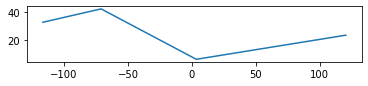

In [47]:
example_11_3_1_1.plot()

In this listing, you start with a 4-point linestring. After segmentizing, you end up with a 3,585-point linestring where the distance between any two adjacent points is no more than 10,000 meters. You cast the geography object to a geometry to use the `ST_NPoints` function. The `ST_NPoints` function does not exist for geography.

As mentioned earlier, `ST_Subdivide` is often used with `ST_Segmentize`. This is because `ST_Subdivide` cuts at vertices, so if you wanted to then break apart your linestring into separate linestrings, you can use `ST_Subdivide`, but need to first cast to geometry and then back to geography as follows:

In [49]:
#This is our linestring
sql = """
SELECT
    sd.geom::geography AS geo,
    ST_NPoints(sd.geom) AS np_after
FROM ST_GeogFromText(
    'LINESTRING(-117.16 32.72,-71.06 42.35,3.3974 6.449,120.96 23.70)'
) AS geog,
  LATERAL ST_Subdivide( ST_Segmentize(geog,10000)::geometry,
                  3585/8) AS sd(geom);
"""

example_11_3_1_2 = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geo") #Note change of geom_col!
example_11_3_1_2.head()

,geo,np_after
0,"LINESTRING (-117.16000 32.72000, -117.08387 32...",270
1,"LINESTRING (-94.55382 40.08841, -94.49497 40.1...",236
2,"LINESTRING (-71.94764 42.35359, -71.84901 42.3...",152
3,"LINESTRING (-57.63000 40.52939, -57.54303 40.5...",367
4,"LINESTRING (-27.86500 29.73958, -27.81249 29.7...",230


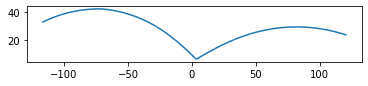

In [50]:
example_11_3_1_2.plot()

# Scaling
Textbook Chapter/Section: 11.4.2 \
Textbook Start Page: 337

The scaling family of functions comes in four overloads, one for 2D `ST_Scale(geometry, xfactor, yfactor)`, one for 3D `ST_Scale(geometry, xfactor, yfactor, zfactor)`, one for any geometry dimension but will scales the coordinates based on a factor specified as a point `ST_Scale(geometry, factor)`, and the newest addition introduced in PostGIS 2.5 is a version that will scale same amount but about a specfied point `ST_Scale(geom, factor, geometry origin)`. (http://postgis.net/docs/ST_Scale.html).

Scaling takes a coordinate and multiplies it by the factor parameters. If you pass in a factor between 1 and -1, you shrink the geometry. If you pass in negative factors, the geometry will flip in addition to scaling. Below shows an example of scaling a hexagon.

In [68]:
sql = """
SELECT
    xfactor, yfactor, zfactor, geom,                                                                  -- Scale in x and y direction
    ST_Scale(hex.geom, xfactor, yfactor) AS scaled_geometry,                                          -- Scaling values
    ST_Scale(hex.geom, ST_MakePoint(xfactor,yfactor, zfactor) ) AS scaled_using_pfactor               -- Scale using point factor
FROM (
        SELECT ST_GeomFromText(
            'POLYGON((0 0,64 64,64 128,0 192, -64 128,-64 64,0 0))'
        ) AS geom                                                                                     -- Original hexagon
    ) AS hex
    CROSS JOIN
    (SELECT x*0.5 AS xfactor FROM generate_series(1,4) AS x) AS xf
    CROSS JOIN
    (SELECT y*0.5 AS yfactor FROM generate_series(1,4) AS y) AS yf
    CROSS JOIN
    (SELECT z*0.5 AS zfactor FROM generate_series(0,1) AS z) AS zf;
"""
hexagon_orig = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="geom") #Note change of geom_col!
hexagon_orig.head()

,xfactor,yfactor,zfactor,geom,scaled_geometry,scaled_using_pfactor
0,0.5,0.5,0.0,"POLYGON ((0.000 0.000, 64.000 64.000, 64.000 1...",0103000000010000000700000000000000000000000000...,0103000000010000000700000000000000000000000000...
1,1.0,0.5,0.0,"POLYGON ((0.000 0.000, 64.000 64.000, 64.000 1...",0103000000010000000700000000000000000000000000...,0103000000010000000700000000000000000000000000...
2,1.5,0.5,0.0,"POLYGON ((0.000 0.000, 64.000 64.000, 64.000 1...",0103000000010000000700000000000000000000000000...,0103000000010000000700000000000000000000000000...
3,2.0,0.5,0.0,"POLYGON ((0.000 0.000, 64.000 64.000, 64.000 1...",0103000000010000000700000000000000000000000000...,0103000000010000000700000000000000000000000000...
4,0.5,0.5,0.5,"POLYGON ((0.000 0.000, 64.000 64.000, 64.000 1...",0103000000010000000700000000000000000000000000...,0103000000010000000700000000000000000000000000...


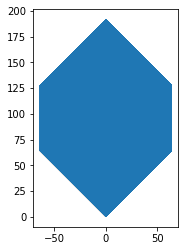

In [69]:
#Original Hexagon
hexagon_orig.plot()

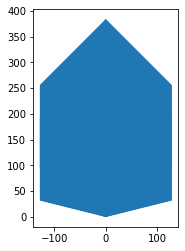

In [70]:
#Scaled Hexagon
hexagon_scaled = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="scaled_geometry") #Note change of geom_col!
hexagon_scaled.plot()

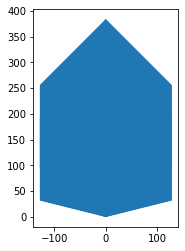

In [71]:
#Scaled Hexagon Point Factor
hexagon_point = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="scaled_using_pfactor") #Note change of geom_col!
hexagon_point.plot()

You start with a hexagonal polygon #1 and shrink and expand the geometry in the X and Y directions from 50% of its size to twice its size by using a cross join that generates numbers from 0 to 2 in X and 0 to 2 in Y, incrementing .5 for each step #2. The results are shown below:

![Image 7](./images/image_7.png)



The scaling multiplies the coordinates. Because the hexagon starts at the origin, all scaled geometries still have their bases at the origin. Normally when you scale, you want to keep the centroid constant. See below for an exampe:

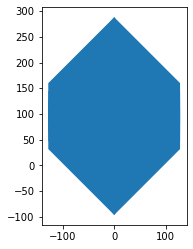

In [72]:
sql = """
SELECT xfactor, yfactor,
        ST_Scale(hex.geom, ST_MakePoint(xfactor, yfactor), ST_Centroid(hex.geom) )
        AS scaled_geometry
FROM (
        SELECT ST_GeomFromText(
            'POLYGON((0 0,64 64,64 128,0 192,-64 128, -64 64,0 0))'
        ) AS geom
    ) AS hex
    CROSS JOIN
    (SELECT x*0.5 AS xfactor FROM generate_series(1,4) AS x) AS xf
    CROSS JOIN
    (SELECT y*0.5 AS yfactor FROM generate_series(1,4) AS y) AS yf;
"""
centroid = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="scaled_geometry") #Note change of geom_col!
centroid.plot()

Here you scale a hexagon from half to twice its size in the X and Y directions about the centroid so the centroid remains unaltered. See below:

![Image 8](./images/image_8.png)

# Rotating
Textbook Chapter/Section: 11.4.3 \
Textbook Start Page: 340

`ST_RotateX`, `ST_RotateY`, `ST_RotateZ`, and `ST_Rotate` rotate a geometry about the `X`, `Y`, or `Z` axis in radian units. `ST_Rotate` and `ST_RotateZ` are the same because the default axis of rotation is `Z`. `ST_RotateX`, `ST_RotateY`, `ST_RotateZ`, and `ST_Rotate` rotate a geometry about the `X`, `Y`, or `Z` axis in radian units. `ST_Rotate` and `ST_RotateZ` are the same because the default axis of rotation is `Z`.

These functions are rarely used in isolation because their default behavior is to rotate the geometry about the `(0,0)` origin rather than about the centroid. You can pass in an optional point argument called `pointOrigin`. When this argument is specified, rotation is about that point; otherwise, rotation is about the origin.

The following listing rotates a hexagon about its centroid in increments of 45 degrees.

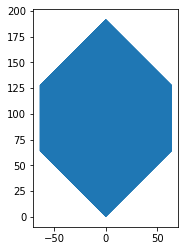

In [78]:
#This is our original hexagon
sql = """
SELECT
    hex.geom as orig_geom,
    rotrad/pi()*180 AS deg,
    ST_Rotate(hex.geom,rotrad,
    ST_Centroid(hex.geom)) AS rotated_geometry
FROM (
        SELECT ST_GeomFromText(
            'POLYGON((0 0,64 64,64 128,0 192,-64 128,-64 64,0 0))'
        ) AS geom
    ) AS hex
CROSS JOIN (
        SELECT 2*pi()*x*45.0/360 AS rotrad
            FROM generate_series(0,6) AS x
) AS xf;
"""
orig_item = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="orig_geom") #Note change of geom_col!
orig_item.plot()

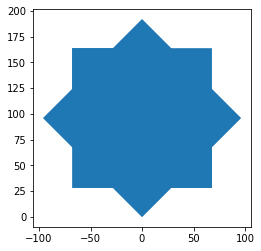

In [80]:
rotate = gpd.GeoDataFrame.from_postgis(sql=sql, con=engine, geom_col="rotated_geometry") #Note change of geom_col!
rotate.plot()

The above plot looks like a big blob...here is a better representation:

![Image 9](./images/image_9.png)